### 1. Загружаем данные + преобразуем "y"

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, roc_curve
import matplotlib.pyplot as plt

data = pd.read_csv("bank.csv", delimiter=';')
columns = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact',
           'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
data = data[columns]
data['y'] = data['y'].map({'yes': 1, 'no': 0})
print(data.iloc[34:40])

    age          job   marital  education  balance housing    contact  day  \
34   49   technician   married   tertiary     1235      no   cellular   13   
35   42       admin.  divorced  secondary     1811     yes    unknown   14   
36   78      retired  divorced    primary      229      no  telephone   22   
37   32  blue-collar   married  secondary     2089     yes   cellular   14   
38   33   management   married  secondary     3935     yes   cellular    6   
39   23     services    single   tertiary      363     yes    unknown   30   

   month  duration  campaign  pdays  previous poutcome  y  
34   aug       354         3     -1         0  unknown  1  
35   may       150         1     -1         0  unknown  0  
36   oct        97         1     -1         0  unknown  1  
37   nov       132         1     -1         0  unknown  1  
38   may       765         1    342         2  failure  1  
39   may        16        18     -1         0  unknown  0  


### 2.Разделим данные на обучающую, валидационную и тестовую выборки в пропорции 60%/20%/20%:

In [54]:
df_train, df_temp = train_test_split(data, test_size=0.4, random_state=1)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=1)

len(df_train), len(df_val), len(df_test)

(2712, 904, 905)

### 3. Вопрос 1: Важность признаков по ROC AUC

In [55]:
numerical = ['balance', 'day', 'duration', 'previous']
auc_scores = {}

for col in numerical:
    auc = roc_auc_score(df_train['y'], df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(df_train['y'], -df_train[col])  # Инвертируем переменную
    auc_scores[col] = auc


max_auc_var = max(auc_scores, key=auc_scores.get)
max_auc_var, auc_scores[max_auc_var]

('duration', np.float64(0.8194790631463028))

#### Ответ: duration

### 4. Вопрос 2: Обучение модели

In [56]:
dv = DictVectorizer(sparse=False)
train_dict = df_train.drop(columns=['y']).to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
val_dict = df_val.drop(columns=['y']).to_dict(orient='records')
X_val = dv.transform(val_dict)


model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, df_train['y'])
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(df_val['y'], y_pred)
round(auc, 3)

np.float64(0.857)

### 5. Вопрос 3: Точность и полнота

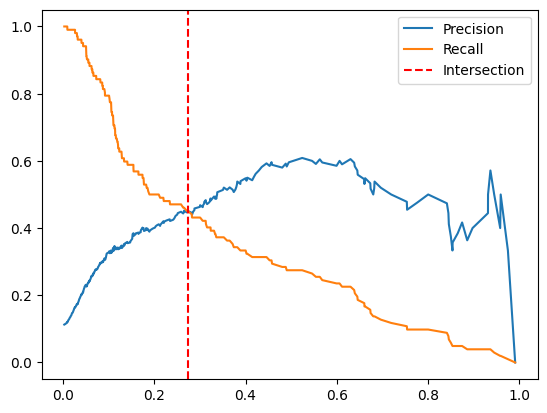

In [10]:
precisions, recalls, thresholds = precision_recall_curve(df_val['y'], y_pred)

# Находим точку пересечения
for i, threshold in enumerate(thresholds):
    if round(precisions[i], 3) == round(recalls[i], 3):
        intersect_threshold = threshold
        break
intersect_threshold

plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.axvline(intersect_threshold, color='red', linestyle='--', label='Intersection')
plt.legend()
plt.show()

#### Ответ: 0.265

### 6. Вопрос 4: F1 Score

In [47]:
precisions, recalls, thresholds = precision_recall_curve(df_val['y'], y_pred)
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
best_threshold = thresholds[np.argmax(f1_scores)]
print("Лучший порог для F1:", best_threshold)

Лучший порог для F1: 0.002215251383348695


C:\Users\semen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


### 7. Вопрос 5: Кросс-валидация

In [49]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

for train_idx, val_idx in kf.split(df_train):
    fold_train = df_train.iloc[train_idx]
    fold_val = df_train.iloc[val_idx]
    train_dict = fold_train.drop(columns=['y']).to_dict(orient='records')
    X_fold_train = dv.fit_transform(train_dict
    val_dict = fold_val.drop(columns=['y']).to_dict(orient='records')
    X_fold_val = dv.transform(val_dict)
    model.fit(X_fold_train, fold_train['y'])
    y_pred = model.predict_proba(X_fold_val)[:, 1]
    auc = roc_auc_score(fold_val['y'], y_pred)
    auc_scores.append(auc)


np.std(auc_scores, ddof=1)

np.float64(0.024150781427385734)

### 8. Вопрос 6: Тюнинг гиперпараметров

In [52]:
C_values = [0.000001, 0.001, 1]
mean_scores = []
std_scores = []

for C in C_values:
    auc_scores = []
    for train_idx, val_idx in kf.split(df_train):
        fold_train = df_train.iloc[train_idx]
        fold_val = df_train.iloc[val_idx]

        train_dict = fold_train.drop(columns=['y']).to_dict(orient='records')
        X_fold_train = dv.fit_transform(train_dict)

        val_dict = fold_val.drop(columns=['y']).to_dict(orient='records')
        X_fold_val = dv.transform(val_dict)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_fold_train, fold_train['y'])
        y_pred = model.predict_proba(X_fold_val)[:, 1]

        auc = roc_auc_score(fold_val['y'], y_pred)
        auc_scores.append(auc)

    mean_scores.append(np.mean(auc_scores))
    std_scores.append(np.std(auc_scores, ddof=1))

# Результаты
best_C = C_values[np.argmax(mean_scores)]
best_C

1